# TOXIC COMMENT CLASSIFICATION EDA

The project aims to build a multi-labeled classification model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate. I will use a dataset of comments from Wikipedia’s talk page edits, collected by Kaggle. Improvements to the current model will hopefully help online discussion become more productive and respectful.

<font color = 'blue'>

    
1. [Read and Check Data](#1)
2. [Data Analysis](#2)
3. [WordClouds](#3)
4. [Preprocessing Steps](#4)
5. [Frequency Distribution of Words](#5)
6. [What's Next?](#6)


<font size="+2" color="black"><b> Read and Check Data </b></font><br><a id="1"></a>

In [ ]:
import numpy as np
import pandas as pd
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud, STOPWORDS

import collections
from tqdm import tqdm

import string
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
train[labels] = train[labels].astype(np.int8)
target = train[labels]
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


The training data contains 159571 observations with 8 columns and the test data contains 153164 observations with 2 columns.

Difference between multi-class classification & multi-label classification is that in multi-class problems the classes are mutually exclusive, whereas for multi-label problems each label represents a different classification task, but the tasks are somehow related. For example, in our case a comment may be toxic, obscene and insulting at the same time. It may also happen that the comment is non-toxic and hence does not belong to any of the six labels.

<font size="+2" color="black"><b> Data Analysis </b></font><br><a id="2"></a>

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int8  
 3   severe_toxic   159571 non-null  int8  
 4   obscene        159571 non-null  int8  
 5   threat         159571 non-null  int8  
 6   insult         159571 non-null  int8  
 7   identity_hate  159571 non-null  int8  
dtypes: int8(6), object(2)
memory usage: 3.3+ MB


There is no nan values

* There are 159571 comments, 143346 of them never contain words that could be considered as toxic (~ 90%). 16225 of them have toxic words.
* One out of 10 comments is toxic.

In [ ]:
# label = ['Non-Toxic Comments', 'Toxic Comments']
values = [len(train[train[labels].eq(0).all(1)]),len(train[~train[labels].eq(0).all(1)])]


fig = px.pie(values=values, names=['Non-Toxic Comments', 'Toxic Comments'], title='Percentage of Comments that are Toxic and Non-Toxic',
             color_discrete_sequence=px.colors.qualitative.Set2, hole=.3)
fig.show()



According to train data, if a comment is severe toxic, it is also toxic.

In [ ]:
train[train.severe_toxic == 1]['toxic'].unique()

array([1], dtype=int8)

Below is a plot showing the comment length frequency. As noticed, most of the comments are short with only a few comments longer than 1000 words.

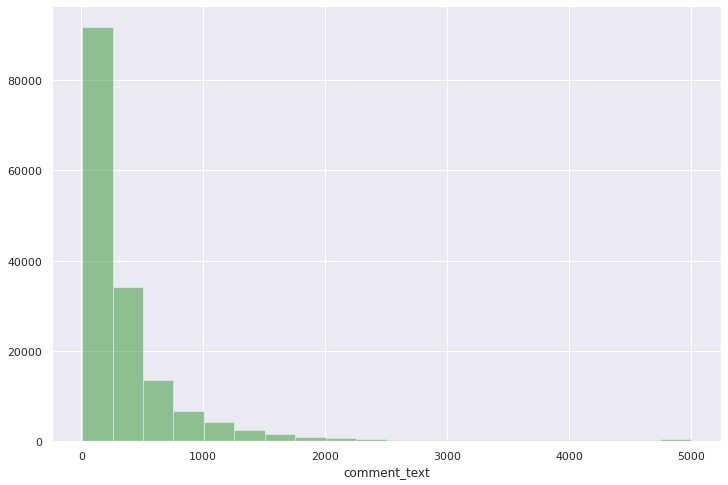

In [ ]:
plt.figure(figsize = (12,8))
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="green")

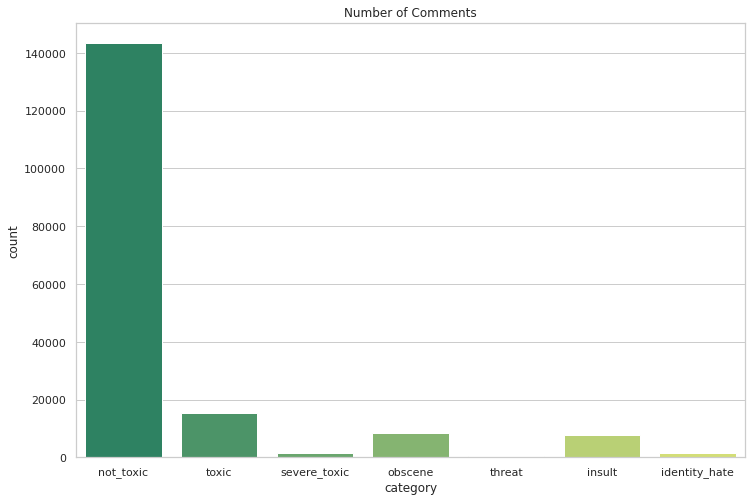

In [ ]:
counts = []
counts.append(('not_toxic',len(train[train[labels].eq(0).all(1)])))
for i in labels:
    counts.append((i, train[i].sum()))
df = pd.DataFrame(counts, columns=['category', 'count'])
plt.figure(figsize = (12,8))
sns.set(style="whitegrid")
sns.barplot(x='category', y='count', data=df, palette="summer")
plt.title("Number of Comments")
plt.show()


The vast majority of comments are non-toxic and as can be seen there is an imbalance between classes that are considered toxic.

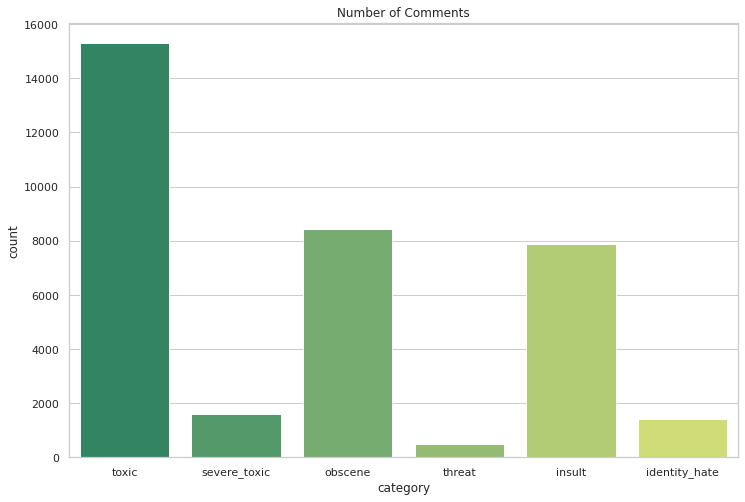

In [ ]:
counts = []
for i in labels:
    counts.append((i, train[i].sum()))
df = pd.DataFrame(counts, columns=['category', 'count'])
plt.figure(figsize = (12,8))
sns.set(style="whitegrid")
sns.barplot(x='category', y='count', data=df, palette="summer")
plt.title("Number of Comments")
plt.show()

It is shows that label 'toxic' has the most observations in the training dataset while threat has the least.

16225 comments contain toxicity but 35098 labels exist. Let's check how many comments have multiple labels?

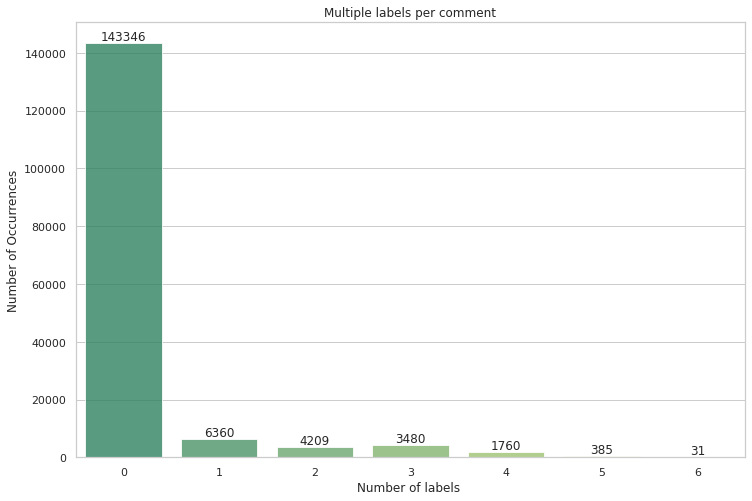

In [ ]:
numoflabel = train.iloc[:,2:].sum(axis=1).value_counts()

plt.figure(figsize=(12,8))
ax = sns.barplot(numoflabel.index, numoflabel.values, alpha=0.8,palette="summer")
plt.title("Multiple labels per comment")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of labels ', fontsize=12)

#adding the text labels
rects = ax.patches
labels_v = numoflabel.values
for rect, label in zip(rects, labels_v):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Below is the plot for the labeled data frequency. There is significant class imbalance since majority of the comments are considered non-toxic.

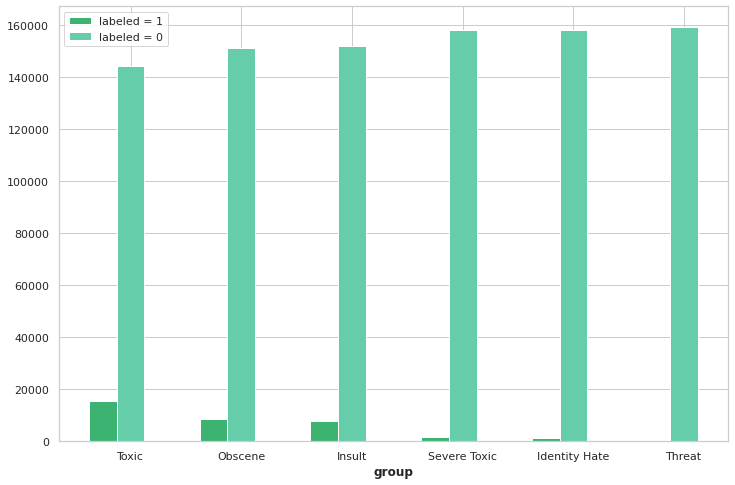

In [ ]:
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(12,8))
plt.bar(r1, bars1, color='mediumseagreen', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='mediumaquamarine', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.show()

In [ ]:
word_counter = collections.Counter([word for sentence in tqdm(train['comment_text'], total=len(train['comment_text'])) for word in sentence.split()])

print('{} words.'.format(len([word for sentence in train['comment_text'] for word in sentence.split()])))
print('{} unique words.'.format(len(word_counter)))
print('10 Most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_counter.most_common(10)))[0]) + '"')

100%|██████████| 159571/159571 [00:01<00:00, 95343.87it/s]


10734904 words.
532299 unique words.
10 Most common words in the dataset:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


The dataset contains 10734904 words, 532299 of which are unique.

The  most common 10 words: "the", "to", "of", "and", "a", "I", "is", "you", "that", and "in".

One problem here is that we are counting uppercase words as different from lower case words and a bunch of other symbols that aren't really useful for our goal. So we hsve to clean the data

To get a better understanding of what the comments look like, below are examples of one  (non-toxic) comment and one toxic (specifically, with label "toxic") comment.

In [ ]:
print(train[train[labels].eq(0).all(1)].iloc[0, 1])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [ ]:
print(train[train.toxic==1].iloc[3,1])

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


And as we can see there are ip addresses and user nicknames in the comments. We should handle them.

In [ ]:
print(train[train.severe_toxic==1].iloc[3,1])

Hi 

Im a fucking bitch.

50.180.208.181


<font size="+2" color="black"><b> Wordclouds </b></font><br><a id="3"></a>

In order to get an idea of what are the words that contribute the most to different labels, let's take a look at words that are associated with these classes.

The visuals here are word clouds. More frequent words appear with bigger size.

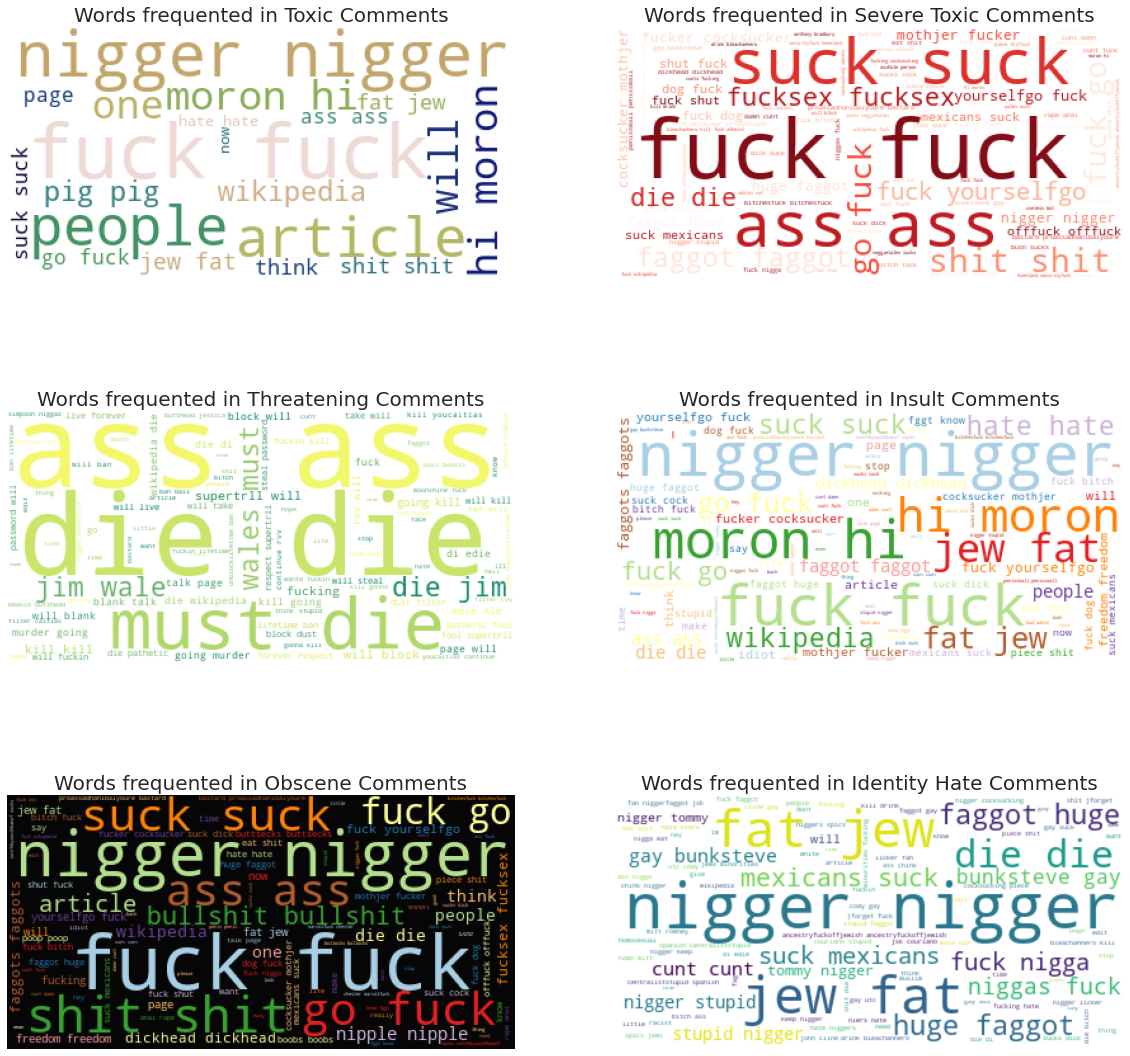

In [ ]:
stopword = set(STOPWORDS)
#toxic
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=20,stopwords=stopword).generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(321)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#severe_toxic
plt.subplot(322)
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=100,stopwords=stopword).generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(323)
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=100,stopwords=stopword).generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), alpha=0.98)

#insult
plt.subplot(324)
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=100,stopwords=stopword).generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

#obscene
plt.subplot(325)
subset=train[train.obscene==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100,stopwords=stopword).generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

#Identity_hate
plt.subplot(326)
subset=train[train.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(max_font_size=50,background_color="white",max_words=100,stopwords=stopword).generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Identity Hate Comments", fontsize=20)
plt.imshow(wc, interpolation="bilinear")

plt.show()



<font size="+2" color="black"><b> Preprocessing Steps  </b></font><br><a id="4"></a>

Before fitting models, we need to break down the sentence into unique words by tokenizing the comments.First of all, I rewrite the two words that each contraction stands for (i.e. won't -> will not), and the meanings that express the emojis. After that we will lowercase the letters, clear the comments from the ip address and punctuations.

In [ ]:
appo = {
"aren't" : "are not",
"can't" : "can not",
"couldn't" : "could not",
"didn't" : "did not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "i would",
"i'd" : "i had",
"i'll" : "i will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't" : "was not",
"we'll" : " will",
"tryin'" : "trying",
"yay!" : " good ",
"yay" : " good ",
"yaay" : " good ",
"yaaay" : " good ",
"yaaaay" : " good ",
"yaaaaay" : " good ",
":/" : " bad ",
":&gt;" : " sad ",
":')" : " sad ",
":-(" : " frown ",
":(" : " frown ",
":s": " frown ",
":-s": " frown ",
"&lt;3": " heart ",
":d": " smile ",
":p": " smile ",
":dd": " smile ",
"8)": " smile ",
":-)": " smile ",
":)": " smile ",
";)": " smile ",
"(-:": " smile ",
"(:": " smile ",
":/": " worry ",
":&gt;": " angry ",
":')": " sad ",
":-(": " sad ",
":(": " sad ",
":s": " sad ",
":-s": " sad ",
r"\br\b": "are",
r"\bu\b": "you",
r"\bhaha\b": "ha",
r"\bhahaha\b": "ha",
r"\bdon't\b": "do not",
r"\bdoesn't\b": "does not",
r"\bdidn't\b": "did not",
r"\bhasn't\b": "has not",
r"\bhaven't\b": "have not",
r"\bhadn't\b": "had not",
r"\bwon't\b": "will not",
r"\bwouldn't\b": "would not",
r"\bcan't\b": "can not",
r"\bcannot\b": "can not",
r"\bi'm\b": "i am",
"m": "am",
"r": "are",
"u": "you",
"haha": "ha",
"hahaha": "ha",
"doesn't": "does not",
"cannot": "can not",
"its" : "it is",
"'s" : " is",
"d'aww!":"cute"
}

In [ ]:
keys = [i for i in appo.keys()]

new_train_data = []
ltr = train["comment_text"].tolist()
for i in ltr:
    arr = str(i).split()
    xx = ""
    for j in arr:
        j = str(j).lower()
        if j[:4] == 'http' or j[:3] == 'www':
            continue
        if j in keys:
            # print("inn")
            j = appo[j]
        xx += j + " "
    new_train_data.append(xx)

train["new_comment_text"] = new_train_data

In [ ]:
new_test_data = []
lte = test["comment_text"].tolist()

for i in lte:
    arr = str(i).split()
    xx = ""
    for j in arr:
        j = str(j).lower()
        if j[:4] == 'http' or j[:3] == 'www':
            continue
        if j in keys:
            # print("inn")
            j = appo[j]
        xx += j + " "
    new_test_data.append(xx)

test["new_comment_text"] = new_test_data


In [ ]:
trate = train["new_comment_text"].tolist()
tete = test["new_comment_text"].tolist()

In [ ]:
for i, c in enumerate(trate):
    trate[i] = re.sub('[^a-zA-Z ?!]+', '', str(trate[i]).lower())
    trate[i] = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",trate[i]) #remove ip
    trate[i] = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]').sub(" ", trate[i])
for i, c in enumerate(tete):
    tete[i] = re.sub('[^a-zA-Z ?!]+', '', tete[i])
    tete[i] = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",tete[i])
    tete[i] = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]').sub(" ", tete[i])
train["comment_text"] = trate
test["comment_text"] = tete
train.drop(["new_comment_text"], axis=1, inplace=True)
test.drop(["new_comment_text"], axis=1, inplace=True)

In [ ]:
trate[0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now '

<font size="+2" color="black"><b> Frequency Distribution of Words  </b></font><br><a id="5"></a>

Let's look at frequency distribution of the words. Let's consider taking words one at a time (Unigrams)

Firstly, we will tokenize the comments and clean the stopwords from all corpus. This step is very important.

In [ ]:
eng_stopwords = set(stopwords.words("english"))

def tokenize_stopwords(comment):
    words = word_tokenize(comment)
    words=[WordNetLemmatizer().lemmatize(word) for word in words]
    words = [w for w in words if not w in eng_stopwords]
    clean_sent=" ".join(words)
    return (clean_sent)



When clean the stopwords:

In [ ]:
tokenize_stopwords(trate[0])

'explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired'

In [ ]:
clean_corpus = train["comment_text"].apply(lambda x : tokenize_stopwords(x))

In [ ]:
clean_corpus

0         explanation edits made username hardcore metal...
1         cute match background colour seemingly stuck t...
2         hey man really trying edit war guy constantly ...
3         make real suggestion improvement wondered sect...
4                             sir hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm actual article prostitution ring c...
159569    look like wa actually put speedy first version...
159570    really think understand came idea wa bad right...
Name: comment_text, Length: 159571, dtype: object

In [ ]:
train['comment_text'] = clean_corpus

We did create a vocabulary(dictionary) of words and then  we will create a sparse matrix of word counts for the words in the sentence that are present in the dictionary.

TF-IDF Vectorizer:
* TF - Term Frequency -> Count of the words(Terms) in the text corpus
* IDF - Inverse Document Frequency -> Penalizes words that are too frequent. We can think of this as regularization

In [ ]:
word_vectorizer = TfidfVectorizer(min_df=200,  max_features=10000,
                  strip_accents='unicode', analyzer='word',ngram_range=(1,1),
                  use_idf=1,smooth_idf=1,sublinear_tf=1,
                  stop_words = 'english')

word_vectorizer.fit(clean_corpus)
features = np.array(word_vectorizer.get_feature_names())

train_unigrams =  word_vectorizer.transform(clean_corpus.iloc[:train.shape[0]])

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''

    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train.iloc[:,2:].columns
    for col in cols:
        ids = train.iloc[:,2:].index[train.iloc[:,2:][col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs



In [ ]:
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

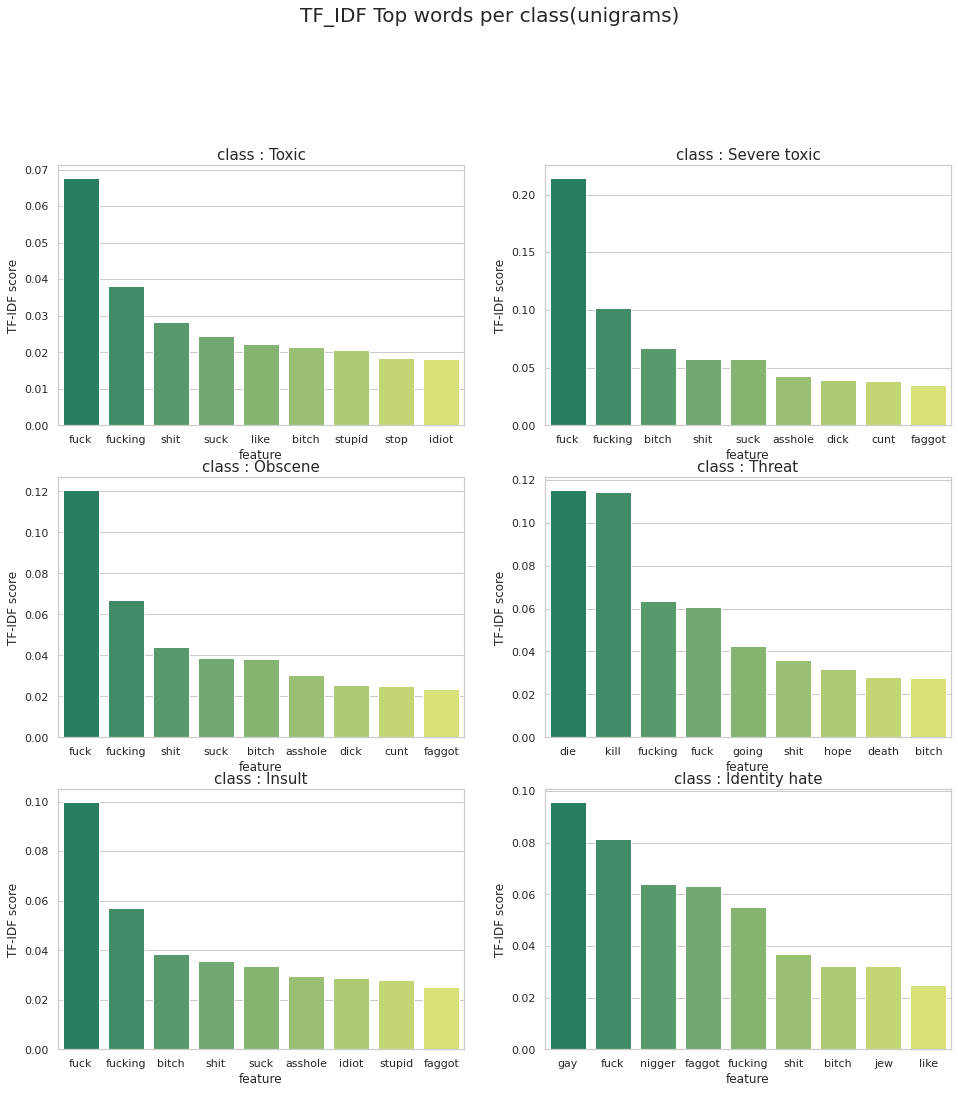

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9], palette="summer")
plt.title("class : Toxic",fontsize=15)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],palette="summer")
plt.title("class : Severe toxic",fontsize=15)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],palette="summer")
plt.title("class : Obscene",fontsize=15)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],palette="summer")
plt.title("class : Threat",fontsize=15)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],palette="summer")
plt.title("class : Insult",fontsize=15)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],palette="summer")
plt.title("class : Identity hate",fontsize=15)
plt.ylabel('TF-IDF score', fontsize=12)


plt.show()

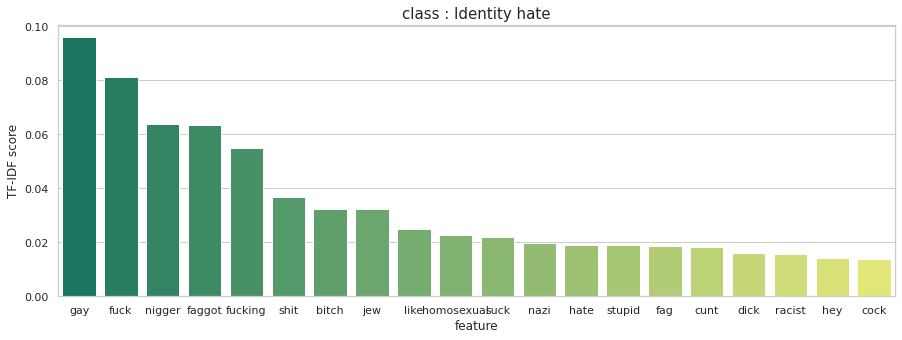

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:20],tfidf_top_n_per_lass[5].tfidf.iloc[0:20],palette="summer")
plt.title("class : Identity hate",fontsize=15)
plt.ylabel('TF-IDF score', fontsize=12)


plt.show()

The most frequent words according to labels in train data

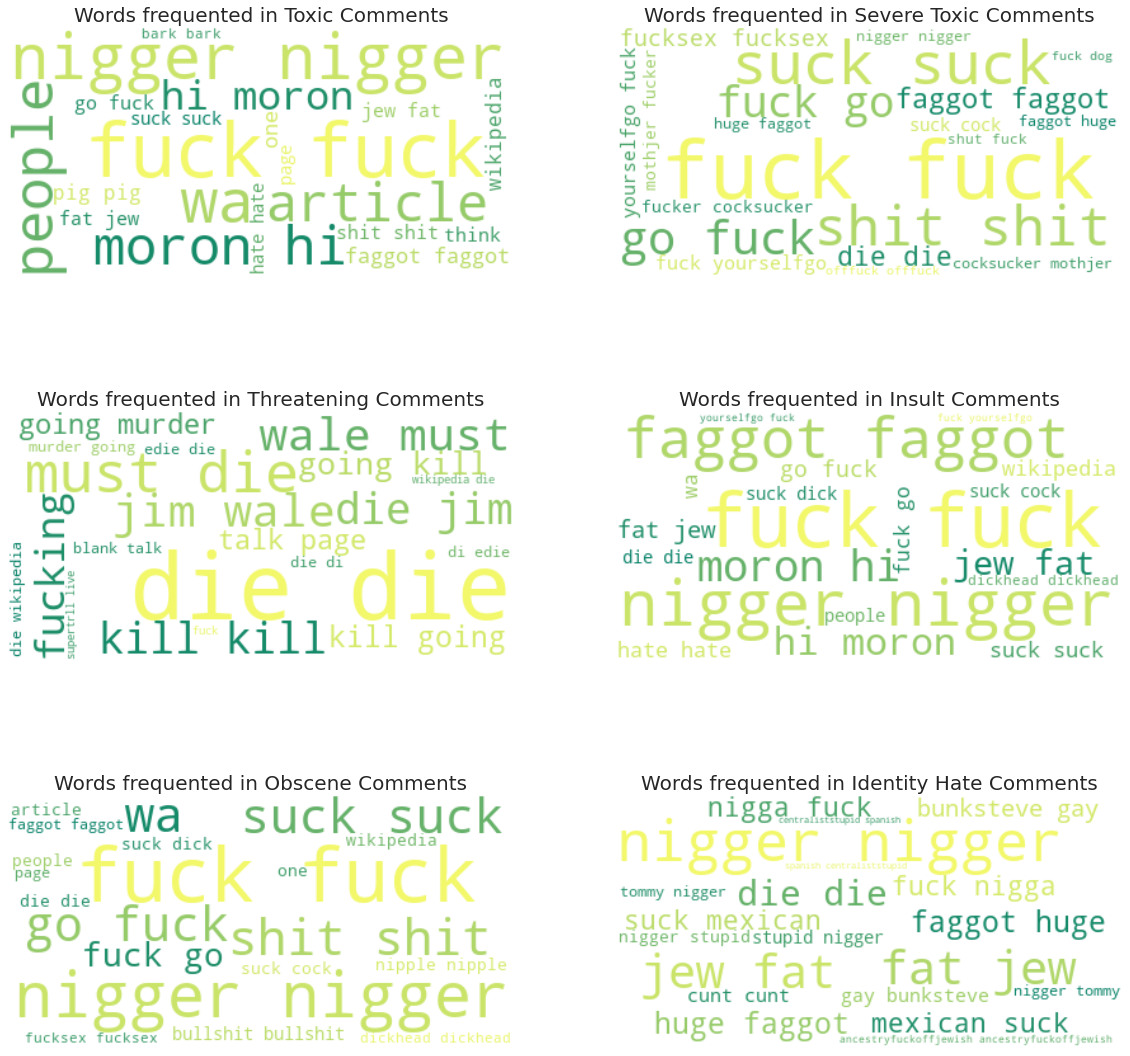

In [ ]:
stopword = set(STOPWORDS)
#toxic
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=20,stopwords=stopword).generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(321)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244),interpolation="bilinear",  alpha=0.98)

#severe_toxic
plt.subplot(322)
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=20,stopwords=stopword).generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244),interpolation="bilinear",  alpha=0.98)

#Threat comments
plt.subplot(323)
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=20,stopwords=stopword).generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), interpolation="bilinear", alpha=0.98)

#insult
plt.subplot(324)
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=20,stopwords=stopword).generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), interpolation="bilinear", alpha=0.98)

#obscene
plt.subplot(325)
subset=train[train.obscene==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=20,stopwords=stopword).generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), interpolation="bilinear",alpha=0.98)

#Identity_hate
plt.subplot(326)
subset=train[train.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=20,stopwords=stopword).generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Identity Hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), interpolation="bilinear",alpha=0.98)

plt.show()



<font size="+2" color="black"><b> What's Next? </b></font><br><a id="6"></a>

Now it's time to selecet baseline model for classification.

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers, initializers, optimizers, constraints
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import SpatialDropout1D
from keras.layers import concatenate,  Bidirectional
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.engine.topology import Layer
import sys
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve

MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.1   # data for validation (not used in training)
EMBEDDING_DIM = 300      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "/content/glove.840B."+str(EMBEDDING_DIM)+"d.txt"

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

tokenizer = Tokenizer(num_words=MAX_NB_WORDS) # define Tokenize text function
tokenizer.fit_on_texts(comments)#fit the function on the text
sequences = tokenizer.texts_to_sequences(comments)# convert  to sequence
test_sequences = tokenizer.texts_to_sequences(test_comments)
word_index = tokenizer.word_index #num of unique tokens

#Limit size  to 200 and pad the sequence
data = pad_sequences(sequences, padding = 'post',truncating='post', maxlen = MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(test_sequences, padding = 'post',truncating='post', maxlen = MAX_SEQUENCE_LENGTH)

embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')

for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...")
print(f'Found {len(embeddings_index)} word vectors', end="")

nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

x = Embedding(nb_words,
              EMBEDDING_DIM,
              weights = [embedding_matrix],
              input_length = MAX_SEQUENCE_LENGTH,
              trainable=True)
embedded_sequences = x(sequence_input)
x = Bidirectional(LSTM(200,return_sequences=True))(embedded_sequences)
x = GlobalMaxPool1D()(x)

x = Dense(75, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

model = Model(inputs=[sequence_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X_tra, X_val, y_tra, y_val = train_test_split(data, y_train, train_size=0.8, random_state=233)
model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val]
hist_adam = model.fit(X_tra, y_tra, batch_size=400, epochs=20, validation_data=(X_val, y_val),callbacks = callbacks_list,verbose=1)
print('Predicting....')
y_pred_Adam_pre = model.predict(data_test,batch_size=1024,verbose=1)

submission = pd.read_csv('/content/submission_gru.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred_Adam_pre
submission.to_csv('lstm_glove840_Adam_yesprocess.csv', index=False)

FileNotFoundError: ignored